In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt #Gráficos
import seaborn as sns #Gráficos
sns.set()
plt.rcParams["figure.figsize"] = (14,4) #tamaño gráficos

from sklearn.preprocessing import LabelEncoder, OneHotEncoder #Tranformacíon variables categóricas (encoding: pasar categorias a números)
from sklearn.preprocessing import MinMaxScaler, StandardScaler #Tranformacíon variables numéricas (normalización)
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, auc, plot_roc_curve, mean_squared_error #Métricas de error y para comparar modelos
from sklearn.feature_selection import chi2, f_classif
from sklearn import metrics, tree, linear_model
from sklearn.linear_model import LogisticRegression #Modelo de Regresión Logística
from sklearn.neighbors import KNeighborsClassifier #Modelo tipo kNN
from sklearn.tree import DecisionTreeClassifier #Modelo tipo árbol de decisión
from sklearn.model_selection import train_test_split #separación train y test

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [2]:
tls201 = pd.read_excel('/Users/jorgeblasco/Desktop/tfg/bbdd/PATSTAT_Sample_2022Spring_CSV/Datos xlsx/tls/tls201_appln.xlsx')
tls206 = pd.read_excel('/Users/jorgeblasco/Desktop/tfg/bbdd/PATSTAT_Sample_2022Spring_CSV/Datos xlsx/tls/tls206_person.xlsx')
tls207 = pd.read_excel('/Users/jorgeblasco/Desktop/tfg/bbdd/PATSTAT_Sample_2022Spring_CSV/Datos xlsx/tls/tls207_pers_appln.xlsx')
tls209 = pd.read_excel('/Users/jorgeblasco/Desktop/tfg/bbdd/PATSTAT_Sample_2022Spring_CSV/Datos xlsx/tls/tls209_appln_ipc.xlsx')
tls212 = pd.read_csv('/Users/jorgeblasco/Desktop/tfg/bbdd/PATSTAT_Sample_2022Spring_CSV/Datos xlsx/tls/tls212_citation.csv', sep=';')
tls229 = pd.read_excel('/Users/jorgeblasco/Desktop/tfg/bbdd/PATSTAT_Sample_2022Spring_CSV/Datos xlsx/tls/tls229_appln_nace2.xlsx')

In [3]:
tls201 = tls201[['appln_id', 'appln_kind', 'ipr_type', 'granted']]
tls206 = tls206[['person_id', 'psn_sector']]
tls207 = tls207[['person_id', 'appln_id']]
tls209 = tls209[['appln_id', 'ipc_class_symbol']]
tls212 = tls212[['cited_appln_id', 'citn_origin']]
tls212 = tls212.rename(columns={'cited_appln_id': 'appln_id'})
tls229 = tls229.rename(columns={'weight': 'nace2_weight'})

In [4]:
tls_join = tls201.merge(tls207, on='appln_id', how='left')
tls_join = tls_join.merge(tls206, on='person_id', how='left')
tls_join = tls_join.merge(tls209, on='appln_id', how='left')
tls_join = tls_join.merge(tls212, on='appln_id', how='left')
tls_join = tls_join.merge(tls229, on='appln_id', how='left')

In [5]:
# cambiar tipo de datos a strings (excepto weight)
tls_join['appln_id'] = tls_join['appln_id'].astype(str)
tls_join['appln_kind'] = tls_join['appln_kind'].astype(str)
tls_join['ipr_type'] = tls_join['ipr_type'].astype(str)
tls_join['psn_sector'] = tls_join['psn_sector'].astype(str)
tls_join['ipc_class_symbol'] = tls_join['ipc_class_symbol'].astype(str)
tls_join['citn_origin'] = tls_join['citn_origin'].astype(str)
tls_join['nace2_code'] = tls_join['nace2_code'].astype(str)

In [6]:
# TLS209
# separar ipc_class_symbol
tls_join['ipc_class_symbol'] = tls_join['ipc_class_symbol'].str[0]

# TLS229
# separar nace2_code
tls_join['nace2_code'] = tls_join['nace2_code'].str.split('.').str[0]

In [7]:
# GENERAL
# generar dummies para aplicar one hot encoding
tls_join = pd.get_dummies(tls_join, columns=['appln_kind', 'ipr_type', 'psn_sector', 'ipc_class_symbol', 'citn_origin', 'nace2_code'])
# drop columnas con nan al final del nombre
tls_join = tls_join.drop(tls_join.columns[tls_join.columns.str.endswith('_nan')], axis=1)

In [8]:
# TLS206 y TLS207
# drop person_id
tls_join = tls_join.drop('person_id', axis=1)
# agrupar por appln_id, sumar las columnas dummy asociadas a psn_sector y dividir por el total de esas columnas
psn_sector_cols = [col for col in tls_join.columns if col.startswith('psn_sector')]
tls_join[psn_sector_cols] = tls_join.groupby('appln_id')[psn_sector_cols].transform(lambda x: x/x.sum())
# igualar valores entre filas con mismo appln_id, cogiendo el máximo
tls_join[psn_sector_cols] = tls_join.groupby('appln_id')[psn_sector_cols].transform(lambda x: x.max())

In [9]:
# TLS209
# simplemente sumar las columnas dummy asociadas a ipc_class_symbol
ipc_class_symbol_cols = [col for col in tls_join.columns if col.startswith('ipc_class_symbol')]
tls_join[ipc_class_symbol_cols] = tls_join.groupby('appln_id')[ipc_class_symbol_cols].transform(lambda x: x.sum())

In [10]:
# TLS212
# agrupar por appln_id y sumar las columnas dummy asociadas a citn_origin
citn_origin_cols = [col for col in tls_join.columns if col.startswith('citn_origin')]
tls_join[citn_origin_cols] = tls_join.groupby('appln_id')[citn_origin_cols].transform(lambda x: x.sum())

In [11]:
# TLS229
# multiplicar nace2_weight por las variables dummy de nace2_code
nace2_code_cols = [col for col in tls_join.columns if col.startswith('nace2_code')]
tls_join[nace2_code_cols] = tls_join[nace2_code_cols].multiply(tls_join['nace2_weight'], axis='index')
# igualar valores entre filas con mismo appln_id, cogiendo el máximo
tls_join[nace2_code_cols] = tls_join.groupby('appln_id')[nace2_code_cols].transform(lambda x: x.max())
# drop nace2_weight
tls_join = tls_join.drop('nace2_weight', axis=1)

In [12]:
# GENERAL
# eliminar filas duplicadas (por appln_id)
tls_join = tls_join.drop_duplicates()
# rellenar nans con ceros
tls_join = tls_join.fillna(0)
# cambiar appln_id a índice
tls_join = tls_join.set_index('appln_id')
# remapear valores de granted a 0 y 1
tls_join['granted'] = tls_join['granted'].map({'N': 0, 'Y': 1})

In [13]:
# Modelo de regresion logistica. Seleccionamos las características para enternar el modelo y la variable objetivo
X = tls_join.drop(['granted'], axis=1)
y = tls_join['granted']

In [14]:
# Separar el dataset en train y test. 80% para train y 20% para test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
# Asignar los conjuntos de entrenamiento y prueba a variables separadas
train_tls = pd.concat([X_train, y_train], axis=1)
test_tls = pd.concat([X_test, y_test], axis=1)

In [16]:
# train_tls, variable en formato dataframe que contiene todas las variables del modelo (tanto las características como la variable objetivo) 
train_tls[['granted', 'appln_kind_A ',
       'appln_kind_D ', 'appln_kind_D2', 'appln_kind_E ', 'appln_kind_F ',
       'appln_kind_K ', 'appln_kind_P ', 'appln_kind_T ', 'appln_kind_U ',
       'appln_kind_W ', 'ipr_type_DP', 'ipr_type_PI', 'ipr_type_UM',
       'psn_sector_COMPANY', 'psn_sector_COMPANY GOV NON-PROFIT',
       'psn_sector_COMPANY GOV NON-PROFIT UNIVERSITY',
       'psn_sector_COMPANY UNIVERSITY', 'psn_sector_GOV NON-PROFIT',
       'psn_sector_GOV NON-PROFIT UNIVERSITY', 'psn_sector_HOSPITAL',
       'psn_sector_INDIVIDUAL', 'psn_sector_UNIVERSITY', 'psn_sector_UNKNOWN',
       'ipc_class_symbol_A', 'ipc_class_symbol_B', 'ipc_class_symbol_C',
       'ipc_class_symbol_D', 'ipc_class_symbol_E', 'ipc_class_symbol_F',
       'ipc_class_symbol_G', 'ipc_class_symbol_H', 'ipc_class_symbol_n',
       'citn_origin_APP', 'citn_origin_FOP', 'nace2_code_10', 'nace2_code_11',
       'nace2_code_12', 'nace2_code_13', 'nace2_code_14', 'nace2_code_15',
       'nace2_code_16', 'nace2_code_17', 'nace2_code_18', 'nace2_code_19',
       'nace2_code_20', 'nace2_code_21', 'nace2_code_22', 'nace2_code_23',
       'nace2_code_24', 'nace2_code_25', 'nace2_code_26', 'nace2_code_27',
       'nace2_code_28', 'nace2_code_29', 'nace2_code_30', 'nace2_code_31',
       'nace2_code_32', 'nace2_code_42', 'nace2_code_43', 'nace2_code_62']]

granted  appln_kind_A   appln_kind_D   appln_kind_D2  \
appln_id                                                          
409838071        1              1              0              0   
274144727        1              1              0              0   
49714541         1              1              0              0   
20244643         1              1              0              0   
45410785         1              1              0              0   
...            ...            ...            ...            ...   
48593944         1              1              0              0   
446696222        1              1              0              0   
335177702        0              1              0              0   
505106951        1              1              0              0   
49391534         1              1              0              0   

           appln_kind_E   appln_kind_F   appln_kind_K   appln_kind_P   \
appln_id                                                                
409838071              0              0              0              0   
274144727              0              0              0              0   
49714541               0              0              0              0   
20244643               0              0              0              0   
45410785               0              0              0              0   
...                  ...            ...            ...            ...   
48593944               0              0              0              0   
446696222              0              0              0              0   
335177702              0              0              0              0   
505106951              0              0              0              0   
49391534               0              0              0              0   

           appln_kind_T   appln_kind_U   ...  nace2_code_26  nace2_code_27  \
appln_id                                 ...                                 
409838071              0              0  ...       0.111111       0.000000   
274144727              0              0  ...       0.666667       0.333333   
49714541               0              0  ...       0.000000       0.000000   
20244643               0              0  ...       0.000000       0.000000   
45410785               0              0  ...       0.000000       0.000000   
...                  ...            ...  ...            ...            ...   
48593944               0              0  ...       0.000000       0.000000   
446696222              0              0  ...       0.000000       0.000000   
335177702              0              0  ...       0.000000       0.500000   
505106951              0              0  ...       0.400000       0.000000   
49391534               0              0  ...       0.000000       0.000000   

           nace2_code_28  nace2_code_29  nace2_code_30  nace2_code_31  \
appln_id                                                                
409838071       0.666667            0.0            0.0            0.0   
274144727       0.000000            0.0            0.0            0.0   
49714541        0.000000            0.0            0.0            0.0   
20244643        0.000000            0.0            0.0            0.0   
45410785        0.428571            0.0            0.0            0.0   
...                  ...            ...            ...            ...   
48593944        0.000000            0.0            0.0            0.0   
446696222       1.000000            0.0            0.0            0.0   
335177702       0.000000            0.0            0.0            0.0   
505106951       0.600000            0.0            0.0            0.0   
49391534        1.000000            0.0            0.0            0.0   

           nace2_code_32  nace2_code_42  nace2_code_43  nace2_code_62  
appln_id                                                               
409838071       0.000000            0.0            0.0            0.0  
27414472

In [17]:
# Tamaño del dataset de train y test
print('Train data size: ', train_tls.shape)
print('Test data size: ', test_tls.shape)

Train data size:  (132081, 61)
Test data size:  (33021, 61)


In [18]:
# Observamos los datos de train
train_tls.head()

appln_kind_A   appln_kind_D   appln_kind_D2  appln_kind_E   \
appln_id                                                                
409838071              1              0              0              0   
274144727              1              0              0              0   
49714541               1              0              0              0   
20244643               1              0              0              0   
45410785               1              0              0              0   

           appln_kind_F   appln_kind_K   appln_kind_P   appln_kind_T   \
appln_id                                                                
409838071              0              0              0              0   
274144727              0              0              0              0   
49714541               0              0              0              0   
20244643               0              0              0              0   
45410785               0              0              0              0   

           appln_kind_U   appln_kind_W   ...  nace2_code_27  nace2_code_28  \
appln_id                                 ...                                 
409838071              0              0  ...       0.000000       0.666667   
274144727              0              0  ...       0.333333       0.000000   
49714541               0              0  ...       0.000000       0.000000   
20244643               0              0  ...       0.000000       0.000000   
45410785               0              0  ...       0.000000       0.428571   

           nace2_code_29  nace2_code_30  nace2_code_31  nace2_code_32  \
appln_id                                                                
409838071            0.0            0.0            0.0       0.000000   
274144727            0.0            0.0            0.0       0.000000   
49714541             0.0            0.0            0.0       0.000000   
20244643             0.0            0.0            0.0       0.000000   
45410785             0.0            0.0            0.0       0.285714   

           nace2_code_42  nace2_code_43  nace2_code_62  granted  
appln_id                                                         
409838071            0.0            0.0            0.0        1  
274144727            0.0            0.0            0.0        1  
49714541             0.0            0.0            0.0        1  
20244643             0.0            1.0            0.0        1  
45410785             0.0            0.0            0.0        1  

[5 rows x 61 columns]

In [19]:
# Observamos los datos de test
test_tls.head()

appln_kind_A   appln_kind_D   appln_kind_D2  appln_kind_E   \
appln_id                                                                
525830418              1              0              0              0   
45528678               1              0              0              0   
53568630               1              0              0              0   
339637089              0              0              0              0   
413776185              1              0              0              0   

           appln_kind_F   appln_kind_K   appln_kind_P   appln_kind_T   \
appln_id                                                                
525830418              0              0              0              0   
45528678               0              0              0              0   
53568630               0              0              0              0   
339637089              0              0              0              0   
413776185              0              0              0              0   

           appln_kind_U   appln_kind_W   ...  nace2_code_27  nace2_code_28  \
appln_id                                 ...                                 
525830418              0              0  ...            0.0       1.000000   
45528678               0              0  ...            0.0       0.000000   
53568630               0              0  ...            0.0       0.750000   
339637089              0              1  ...            0.5       0.000000   
413776185              0              0  ...            0.0       0.333333   

           nace2_code_29  nace2_code_30  nace2_code_31  nace2_code_32  \
appln_id                                                                
525830418            0.0            0.0            0.0            0.0   
45528678             0.0            1.0            0.0            0.0   
53568630             0.0            0.0            0.0            0.0   
339637089            0.5            0.0            0.0            0.0   
413776185            0.0            0.0            0.0            0.0   

           nace2_code_42  nace2_code_43  nace2_code_62  granted  
appln_id                                                         
525830418            0.0            0.0            0.0        0  
45528678             0.0            0.0            0.0        1  
53568630             0.0            0.0            0.0        1  
339637089            0.0            0.0            0.0        0  
413776185            0.0            0.0            0.0        1  

[5 rows x 61 columns]

In [20]:
# Estadísticas de train y test, con el número de observaciones, las observaciones únicas, la primera observación, la observación más frecuente, la media, la desviación típica, el mínimo, la mediana y el máximo
print(train_tls.describe(include='all', percentiles=[]))
print(test_tls.describe(include='all', percentiles=[]))

       appln_kind_A   appln_kind_D   appln_kind_D2  appln_kind_E   \
count  132081.000000  132081.000000  132081.000000  132081.000000   
mean        0.744142       0.000863       0.001832       0.000045   
std         0.436344       0.029366       0.042765       0.006740   
min         0.000000       0.000000       0.000000       0.000000   
50%         1.000000       0.000000       0.000000       0.000000   
max         1.000000       1.000000       1.000000       1.000000   

       appln_kind_F   appln_kind_K   appln_kind_P   appln_kind_T   \
count  132081.000000  132081.000000  132081.000000  132081.000000   
mean        0.000984       0.000008       0.000151       0.016354   
std         0.031357       0.002752       0.012304       0.126832   
min         0.000000       0.000000       0.000000       0.000000   
50%         0.000000       0.000000       0.000000       0.000000   
max         1.000000       1.000000       1.000000       1.000000   

       appln_kind_U   appln_kind

In [23]:
tls_join

granted  appln_kind_A   appln_kind_D   appln_kind_D2  \
appln_id                                                          
901569506        0              1              0              0   
902091981        0              1              0              0   
902093027        0              1              0              0   
902094885        0              1              0              0   
902266441        0              1              0              0   
...            ...            ...            ...            ...   
541928368        1              1              0              0   
550803582        1              1              0              0   
550809874        1              1              0              0   
558435541        1              1              0              0   
556330228        1              1              0              0   

           appln_kind_E   appln_kind_F   appln_kind_K   appln_kind_P   \
appln_id                                                                
901569506              0              0              0              0   
902091981              0              0              0              0   
902093027              0              0              0              0   
902094885              0              0              0              0   
902266441              0              0              0              0   
...                  ...            ...            ...            ...   
541928368              0              0              0              0   
550803582              0              0              0              0   
550809874              0              0              0              0   
558435541              0              0              0              0   
556330228              0              0              0              0   

           appln_kind_T   appln_kind_U   ...  nace2_code_26  nace2_code_27  \
appln_id                                 ...                                 
901569506              0              0  ...            0.0            0.0   
902091981              0              0  ...            0.0            0.0   
902093027              0              0  ...            0.0            0.0   
902094885              0              0  ...            0.0            0.0   
902266441              0              0  ...            0.0            0.0   
...                  ...            ...  ...            ...            ...   
541928368              0              0  ...            0.0            0.0   
550803582              0              0  ...            0.0            0.0   
550809874              0              0  ...            0.0            0.0   
558435541              0              0  ...            0.0            0.0   
556330228              0              0  ...            0.0            0.0   

           nace2_code_28  nace2_code_29  nace2_code_30  nace2_code_31  \
appln_id                                                                
901569506            0.0            0.0            0.0            0.0   
902091981            0.0            0.0            0.0            0.0   
902093027            0.0            0.0            0.0            0.0   
902094885            0.0            0.0            0.0            0.0   
902266441            0.0            0.0            0.0            0.0   
...                  ...            ...            ...            ...   
541928368            0.0            0.0            0.0            0.0   
550803582            0.0            0.0            0.0            0.0   
550809874            0.0            0.0            0.0            0.0   
558435541            0.0            0.0            0.0            0.0   
556330228            0.0            0.0            0.0            0.0   

           nace2_code_32  nace2_code_42  nace2_code_43  nace2_code_62  
appln_id                                                               
901569506            0.0            0.0            0.0            0.0  
90209198

In [26]:
len(tls_join.index.unique()), tls_join.shape[0]

(165102, 165102)

In [17]:
# Arbol de decisión
arboldecision = tree.DecisionTreeClassifier()
arboldecision = arboldecision.fit(X_train, y_train)
y_prediccion_ad = arboldecision.predict(X_test)

# Precisión, exhaustividad, puntuación F1 y exactitud
precision_ad = precision_score(y_test, y_prediccion_ad)
recall_ad = recall_score(y_test, y_prediccion_ad)
f1_ad = f1_score(y_test, y_prediccion_ad)
exactitud_ad = accuracy_score(y_test, y_prediccion_ad)

print("Precisión:", precision_ad)
print("Exhaustividad:", recall_ad)
print("Puntuación F1:", f1_ad)
print("Exactitud:", exactitud_ad)

# Matriz de confusión
matriz_confusion_ad = confusion_matrix(y_test, y_prediccion_ad)
print("Matriz de confusión:\n", matriz_confusion_ad)

# Reporte de clasificación
reporte_clasificacion_ad = classification_report(y_test, y_prediccion_ad)
print("Reporte de clasificación:\n", reporte_clasificacion_ad)

Precisión: 0.7325075834175935
Exhaustividad: 0.736229674796748
Puntuación F1: 0.734363912823112
Exactitud: 0.6825656400472426
Matriz de confusión:
 [[ 8050  5291]
 [ 5191 14489]]
Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.61      0.60      0.61     13341
           1       0.73      0.74      0.73     19680

    accuracy                           0.68     33021
   macro avg       0.67      0.67      0.67     33021
weighted avg       0.68      0.68      0.68     33021



In [18]:
# Regresión logística
regresionlogistica = linear_model.LogisticRegression(penalty='l2', C=1.0, solver='liblinear')
regresionlogistica = regresionlogistica.fit(X_train, y_train)
y_prediccion_rl = regresionlogistica.predict(X_test)

# Precisión, exhaustividad, puntuación F1 y exactitud
precision_rl = precision_score(y_test, y_prediccion_rl)
recall_rl = recall_score(y_test, y_prediccion_rl)
f1_rl = f1_score(y_test, y_prediccion_rl)
exactitud_rl = accuracy_score(y_test, y_prediccion_rl)

print("Precisión:", precision_rl)
print("Exhaustividad:", recall_rl)
print("Puntuación F1:", f1_rl)
print("Exactitud:", exactitud_rl)

# Matriz de confusión
matriz_confusion_rl = confusion_matrix(y_test, y_prediccion_rl)
print("Matriz de confusión:\n", matriz_confusion_rl)

# Reporte de clasificación
reporte_clasificacion_rl = classification_report(y_test, y_prediccion_rl)
print("Reporte de clasificación:\n", reporte_clasificacion_rl)

Precisión: 0.6719095132911874
Exhaustividad: 0.8964939024390244
Puntuación F1: 0.7681222517305935
Exactitud: 0.677417401047818
Matriz de confusión:
 [[ 4726  8615]
 [ 2037 17643]]
Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.70      0.35      0.47     13341
           1       0.67      0.90      0.77     19680

    accuracy                           0.68     33021
   macro avg       0.69      0.63      0.62     33021
weighted avg       0.68      0.68      0.65     33021



In [19]:
# KNN vecinos más cercanos
neighbors = KNeighborsClassifier(n_neighbors=8)
neighbors = neighbors.fit(X_train, y_train)
y_prediccion_knn = neighbors.predict(X_test)

# Precisión, exhaustividad, puntuación F1 y exactitud
precision_knn = precision_score(y_test, y_prediccion_knn)
recall_knn = recall_score(y_test, y_prediccion_knn)
f1_knn = f1_score(y_test, y_prediccion_knn)
exactitud_knn = accuracy_score(y_test, y_prediccion_knn)

print("Precisión:", precision_knn)
print("Exhaustividad:", recall_knn)
print("Puntuación F1:", f1_knn)
print("Exactitud:", exactitud_knn)

# Matriz de confusión
matriz_confusion_knn = confusion_matrix(y_test, y_prediccion_knn)
print("Matriz de confusión:\n", matriz_confusion_knn)

# Reporte de clasificación
reporte_clasificacion_knn = classification_report(y_test, y_prediccion_knn)
print("Reporte de clasificación:\n", reporte_clasificacion_knn)

Precisión: 0.735443106923035
Exhaustividad: 0.6860772357723577
Puntuación F1: 0.7099029942953284
Exactitud: 0.6658187214197027
Matriz de confusión:
 [[ 8484  4857]
 [ 6178 13502]]
Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.58      0.64      0.61     13341
           1       0.74      0.69      0.71     19680

    accuracy                           0.67     33021
   macro avg       0.66      0.66      0.66     33021
weighted avg       0.67      0.67      0.67     33021



In [20]:
# Comparación de modelos en una tabla
comparacion_modelos = pd.DataFrame({'Modelo': ['Arbol de decisión', 'Regresión logística', 'KNN'],
                                    'Precisión': [precision_ad, precision_rl, precision_knn],
                                    'Exhaustividad': [recall_ad, recall_rl, recall_knn],
                                    'Puntuación F1': [f1_ad, f1_rl, f1_knn],
                                    'Exactitud': [exactitud_ad, exactitud_rl, exactitud_knn]})
comparacion_modelos

Modelo  Precisión  Exhaustividad  Puntuación F1  Exactitud
0    Arbol de decisión   0.732508       0.736230       0.734364   0.682566
1  Regresión logística   0.671910       0.896494       0.768122   0.677417
2                  KNN   0.735443       0.686077       0.709903   0.665819

<AxesSubplot:title={'center':'Comparación de modelos'}, xlabel='Modelo', ylabel='Valor'>

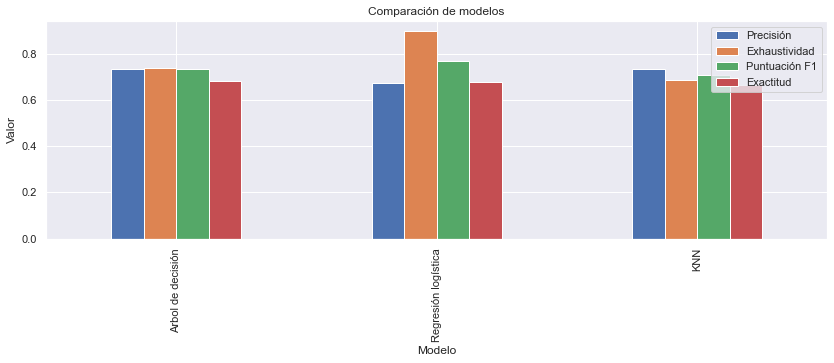

In [21]:
# Gráfico de barras comparando los modelos
comparacion_modelos.plot(x='Modelo', y=['Precisión', 'Exhaustividad', 'Puntuación F1', 'Exactitud'], kind='bar', figsize=(14,4), title='Comparación de modelos', xlabel='Modelo', ylabel='Valor')

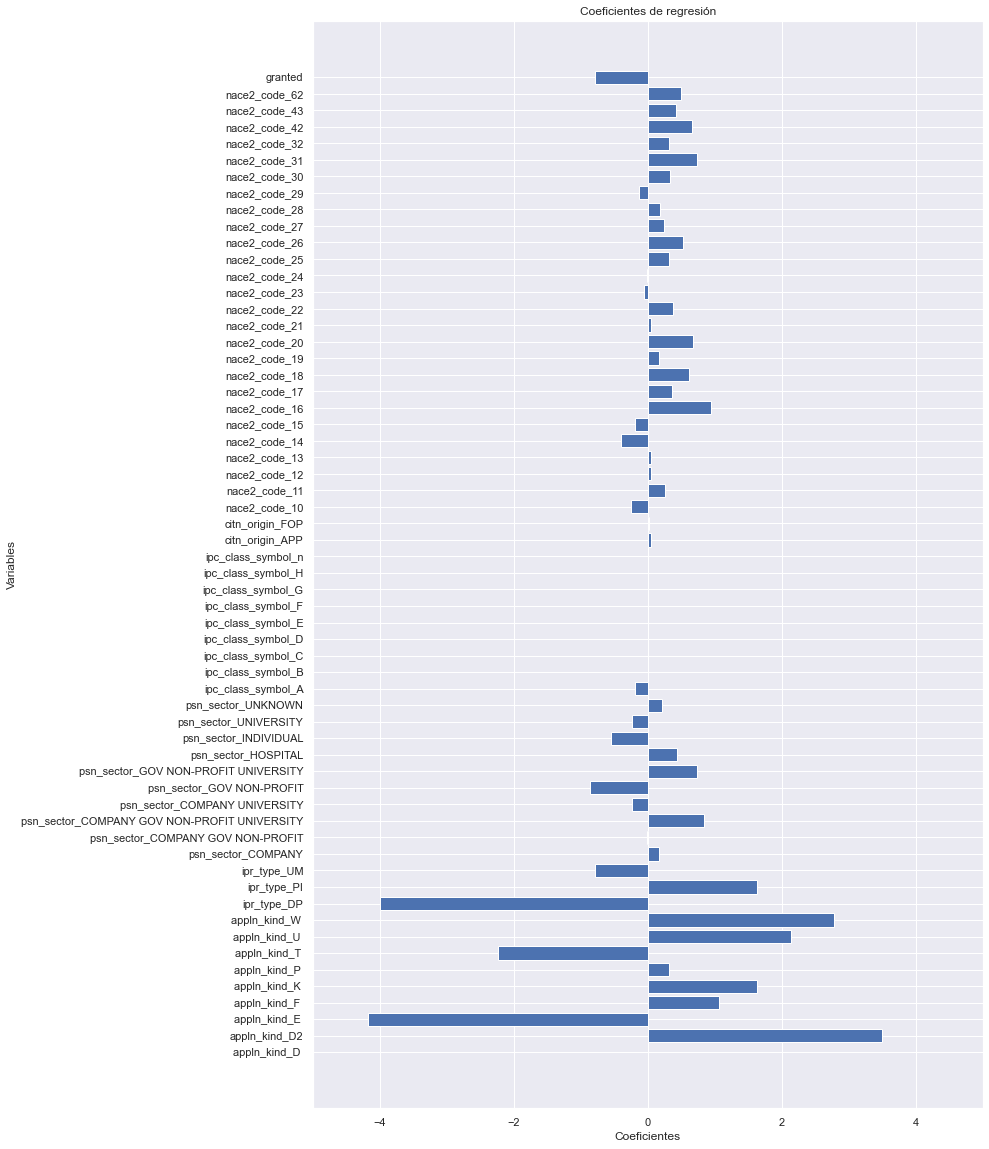

In [22]:
# Obtener los coeficientes del modelo
coeficientes = regresionlogistica.coef_[0]

# Obtener el nombre de las variables dummy
nombres_variables = train_tls.columns[1:]  

# Crear el gráfico de barras
plt.figure(figsize=(12, 20))
plt.barh(nombres_variables, coeficientes)
plt.xlabel('Coeficientes')
plt.ylabel('Variables')
plt.title('Coeficientes de regresión')
plt.xlim(-5, 5)  # Establecer el rango del eje x
plt.show()



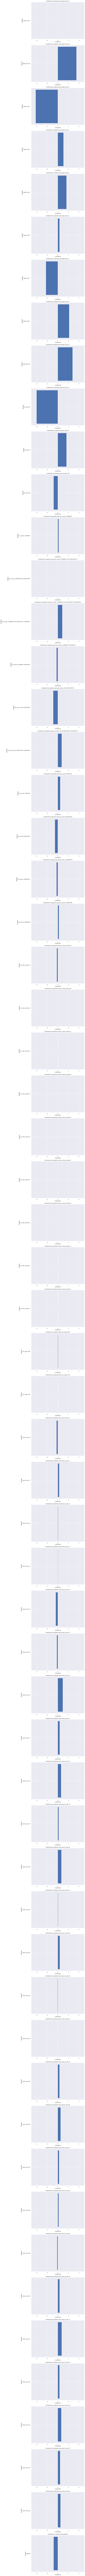

In [23]:
# Obtener los coeficientes del modelo
coeficientes = regresionlogistica.coef_[0]

# Obtener el nombre de las variables dummy excluyendo 'granted'
nombres_variables = train_tls.columns[1:]

# Dividir la gráfica en variables
num_variables = len(nombres_variables)
fig, axs = plt.subplots(num_variables, 1, figsize=(12, 6*num_variables))

# Crear el gráfico de barras para cada variable
for i, variable in enumerate(nombres_variables):
    # Obtener el coeficiente correspondiente a la variable
    coeficiente = coeficientes[i]

    # Crear el gráfico de barras para la variable
    axs[i].barh([variable], [coeficiente])
    axs[i].set_xlabel('Coeficiente')
    axs[i].set_ylabel('Variable')
    axs[i].set_title('Coeficiente de regresión para {}'.format(variable))
    axs[i].set_xlim(-5, 5)  # Establecer el rango del eje x

plt.tight_layout()
plt.show()